# ***<font style="color:black">Base example of RNN nets</font>***
-------------------
---------------

## **<font style="color:blue">Installation and Imports libraries</font>**
-------------------

In [1]:
import os
import time
import numpy as np

from typing import Iterable, Tuple
from dataclasses import dataclass

import torch
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader # Gives easier dataset managment and creates mini batches
from torchvision import datasets, transforms
from torch.utils.data import (
    DataLoader,
) # Gives easier dataset managment by creating mini batches etc.

from tqdm import tqdm # For a nice progree bar

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## **<font style="color:blue">System configuration</font>**
-------------------

In [3]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

## **<font style="color:blue">Training configuration</font>**
-------------------

In [4]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 64  # amount of data to pass through the network at each forward-backward iteration
    input_size: int = 28 # input size of model
    sequence_length: int = 28 # length of sequence of model
    num_layers: int = 2 # number of layers of model
    hidden_size: int = 256 # number of hidden layer of model
    num_classes: int = 10 # number of output classes of model
    num_epochs: int = 5  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    dir_root: str = os.path.join('/kaggle','working') # root directory of project
    data_root: str = os.path.join(dir_root,"dataset")  # folder to save MNIST data (default: data/mnist-data)
    num_workers: int = 10  # number of concurrent processes used to prepare data
    device: str = 'cuda'  # device to use for training.

## **<font style="color:blue">System settings</font>**
-------------------

In [5]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## **<font style="color:blue">Create model</font>**
------------------------

### **<font style="color:green">Recurrent neural network (many-to-one) model</font>**


In [6]:
# Create RNN Network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, sequence_length, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

## **<font style="color:green">Recurrent neural network with GRU (many-to-one) model</font>**

In [7]:
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, sequence_length, num_classes):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

### **<font style="color:green">Recurrent neural network with LSTM (many-to-one) model</font>**

In [8]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, sequence_length, num_classes):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(
            x, (h0, c0)
        )  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

### **<font style="color:green">Bidirectional LSTM model</font>**

In [9]:
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])

        return out

## **<font style="color:blue">Load Data</font>**
--------------------------------

In [10]:
!mkdir /kaggle/working/dataset/

In [11]:
def get_data(batch_size, data_root='/kaggle/working/', num_workers=1):
    data_transforms = transforms.Compose([
        transforms.ToTensor()
    ])

    # train dataloader
    train_loader = DataLoader(
        datasets.MNIST(root=data_root, train=True, download=True, transform=data_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    # test dataloader
    test_loader = DataLoader(
        datasets.MNIST(root=data_root, train=False, download=True, transform=data_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

## **<font style="color:blue">Initialize RNN networks</font>**
--------------------------------------

In [12]:
config_model = TrainingConfiguration()

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [13]:
# Recurrent neural network (many-to-one)
model_rnn = RNN(
    config_model.input_size, 
    config_model.hidden_size, 
    config_model.num_layers, 
    config_model.sequence_length, 
    config_model.num_classes).to(device)
print(model_rnn)

RNN(
  (rnn): RNN(28, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=7168, out_features=10, bias=True)
)


In [14]:
# Recurrent neural network with GRU (many-to-one)
model_rnn_gru = RNN_GRU(
    config_model.input_size, 
    config_model.hidden_size, 
    config_model.num_layers, 
    config_model.sequence_length, 
    config_model.num_classes).to(device)
print(model_rnn_gru)

RNN_GRU(
  (gru): GRU(28, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=7168, out_features=10, bias=True)
)


In [15]:
# Recurrent neural network with LSTM (many-to-one)
model_rnn_lstm = RNN_LSTM(
    config_model.input_size, 
    config_model.hidden_size, 
    config_model.num_layers,
    config_model.sequence_length,
    config_model.num_classes).to(device)
print(model_rnn_lstm)

RNN_LSTM(
  (lstm): LSTM(28, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=7168, out_features=10, bias=True)
)


In [16]:
# Bidirectional LSTM
model_rnn_brnn = BRNN(
    config_model.input_size, 
    config_model.hidden_size, 
    config_model.num_layers, 
    config_model.num_classes).to(device)
print(model_rnn_brnn)

BRNN(
  (lstm): LSTM(28, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)


## **<font style="color:blue">Train Network</font>**
---------------------------

In [17]:
def train(
    train_config: TrainingConfiguration,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    epoch_idx: int
) -> Tuple[float, float]:
    
    # change model in training mode
    model.train()

    # to get batch loss
    batch_loss = np.array([])

    # to get batch accuracy
    batch_acc = np.array([])

    for batch_idx, (data, target) in enumerate(train_loader):
        # clone target
        indx_target = target.clone()

        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device).squeeze(1)

        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()

        # forward pass to the model
        output = model(data)
        # cross entropy loss
        loss = F.cross_entropy(output, target)

        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()

        batch_loss = np.append(batch_loss, [loss.item()])

        # get probability score using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()

        # accuracy
        acc = float(correct) / float(len(data))

        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )

    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    
    return epoch_loss, epoch_acc

## **<font style="color:blue">Validace</font>**
---------------------------

In [18]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> Tuple[float, float]:
    
    model.eval()
    test_loss = 0
    count_corect_predictions = 0

    # turn off gradient-computation
    with torch.no_grad():

        for data, target in test_loader:
            indx_target = target.clone()
            data = data.to(train_config.device).squeeze(1)

            target = target.to(train_config.device)

            output = model(data)
            # add loss for each mini batch
            test_loss += F.cross_entropy(output, target).item()

            # get probability score using softmax
            prob = F.softmax(output, dim=1)

            # get the index of the max probability
            pred = prob.data.max(dim=1)[1]

            # add correct prediction count
            count_corect_predictions += pred.cpu().eq(indx_target).sum()

        # average over number of mini-batches
        test_loss = test_loss / len(test_loader)

        # average over number of dataset
        accuracy = 100. * count_corect_predictions / len(test_loader.dataset)

        print(
            '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
            )
        )
    return test_loss, accuracy/100.0

## **<font style="color:blue">Experiment</font>**
---------------------------

In [19]:
def experiment(
    set_model,
    model_name='model',
    set_optimizer='Adam', # SGD
    system_configuration=SystemConfiguration(), 
    training_configuration=TrainingConfiguration()
):

    setup_system(system_configuration)

    batch_size_to_set = training_configuration.batch_size
    num_workers_to_set = training_configuration.num_workers
    epoch_num_to_set = training_configuration.num_epochs

    if torch.cuda.is_available():
        device = "cuda"
        num_workers_to_set = 2
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 5

    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )

    training_configuration = TrainingConfiguration(
        device=device,
        num_epochs=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    model = set_model
    model.to(training_configuration.device)

    if set_optimizer=='SGD':
        optimizer = optim.SGD(
            model.parameters(),
            lr=training_configuration.learning_rate
        )
    elif set_optimizer=='Adam':
        optimizer = optim.Adam(
            model.parameters(), 
            lr=training_configuration.learning_rate
        )

    best_loss = torch.tensor(np.inf)
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])

    t_begin = time.time()
    for epoch in range(training_configuration.num_epochs):
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.num_epochs - elapsed_time

        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])

            if current_loss < best_loss:
                best_loss = current_loss
                torch.save(model.state_dict(), os.path.join(training_configuration.dir_root,"best_" + model_name + ".pth"))
                print("Best model saved at epoch {} with loss {:.4f}".format(epoch, best_loss))

    torch.save(model.state_dict(), os.path.join(training_configuration.dir_root,"final_" + model_name + ".pth"))
    print("Final model saved.")
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))

    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## **<font style="color:blue">Function for print results</font>**
------------------------------

In [20]:
def plot_results(
    data: list,
    label_names: list,
    name_value: str,
    name_title: str
) -> None:  
    # Plot loss
    plt.rcParams["figure.figsize"] = (10, 6)
    x = range(len(data[0]))
    
    
    plt.figure
    plt.plot(x, data[0], color='r', label=label_names[0])
    plt.plot(x, data[1], color='b', label=label_names[1])
    plt.xlabel('epoch no.')
    plt.ylabel(name_value)
    plt.legend(loc='upper right')
    plt.title(name_title)
    plt.show()

## **<font style="color:blue">Inference on sample images</font>**
------------------------------

In [21]:
 def prediction(model, train_config, batch_input):

    # turn off gradient-computation
    with torch.no_grad():

        # send model to cpu/cuda according to your system configuration
        model.to(train_config.device)

        # it is important to do model.eval() before prediction
        model.eval()

        data = batch_input.to(train_config.device)

        output = model(data)

        # get probability score using softmax
        prob = F.softmax(output, dim=1)

        # get the max probability
        pred_prob = prob.data.max(dim=1)[0]

        # get the index of the max probability
        pred_index = prob.data.max(dim=1)[1]

    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [22]:
def inference_test(
    train_config: TrainingConfiguration,
    model: nn.Module,
    batch_size_set: int
):
    if torch.cuda.is_available():
        train_config.device = "cuda"
    else:
        train_config.device = "cpu"

    image_transforms = transforms.Compose([
        transforms.ToTensor(),
    ])

    test_trans = torch.utils.data.DataLoader(
        datasets.MNIST(root=train_config.data_root, train=False, download=True, transform=image_transforms),
        batch_size=batch_size_set,
        shuffle=False,
        num_workers=1
    )
        
    for data, _ in test_trans:
        data = data.to(train_config.device).squeeze(1)
        # pass the loaded model
        pred, prob = prediction(model, train_config, data)
        break


    plt.rcParams["figure.figsize"] = (3, 3)
    for images, _ in test_trans:
        for i, img in enumerate(images):
            img = transforms.functional.to_pil_image(img)
            plt.imshow(img, cmap='gray')
            plt.gca().set_title('Prediction: {0}, Prob: {1:.2}'.format(pred[i], prob[i]))
            plt.show()
        break
    

-------------
## ***<font style="color:purple">Main part of the program</font>***
--------------------

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.84MB/s]


Extracting /kaggle/working/dataset/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting /kaggle/working/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]


Extracting /kaggle/working/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.42MB/s]

Extracting /kaggle/working/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/dataset/MNIST/raw



Train Epoch: 0 [6400/60000] Loss: 47.071140 Acc: 0.1250
Train Epoch: 0 [12800/60000] Loss: 33.406956 Acc: 0.0625
Train Epoch: 0 [19200/60000] Loss: 16.952827 Acc: 0.0938
Train Epoch: 0 [25600/60000] Loss: 27.640232 Acc: 0.1094
Train Epoch: 0 [32000/60000] Loss: 29.550774 Acc: 0.0938
Train Epoch: 0 [38400/60000] Loss: 17.443819 Acc: 0.0938
Train Epoch: 0 [44800/60000] Loss: 21.829931 Acc: 0.1250
Train Epoch: 0 [51200/60000] Loss: 33.160950 Acc: 0.0938
Train Epoch: 0 [57600/60000] Loss: 24.273731 Acc: 0.0625
Elapsed 6.41s, 6.41 s/epoch, 0.01 s/batch, ets 25.62s

Test set: Average loss: 34.4834, Accuracy: 1028/10000 (10%)

Best model saved at epoch 0 with loss 34.4834
Train Epoch: 1 [6400/60000] Loss: 36.124355 Acc: 0.0781
Train Epoch: 1 [12800/60000] Loss: 34.498905 Acc: 0.1094
Train Epoch: 1 [19200/60000] Loss: 25.644924 Acc: 0.1562
Train Epoch: 1 [25600/60000] Loss: 18.804255 Acc: 0.1094
Train Epoch: 1 [32000/60000] Loss: 51.548328 Acc: 0.0469
Train Epoch: 1 [38400/60000] Loss: 28.5689

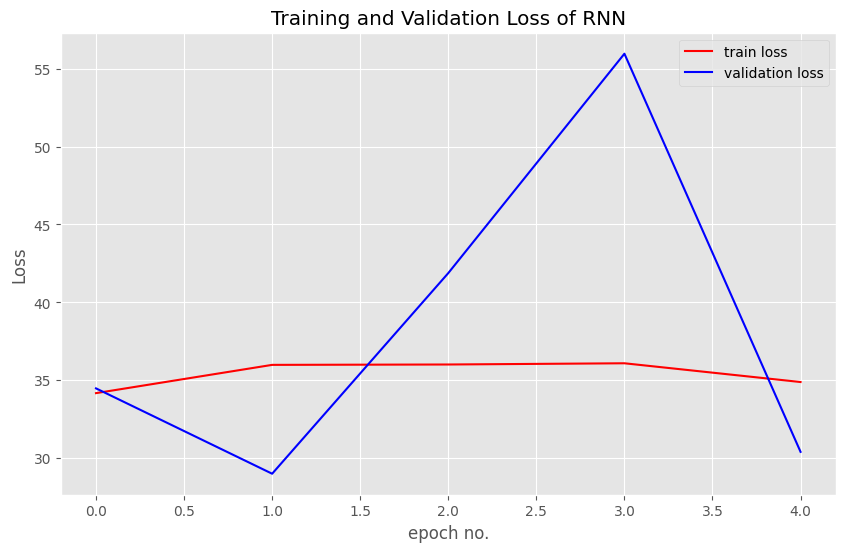

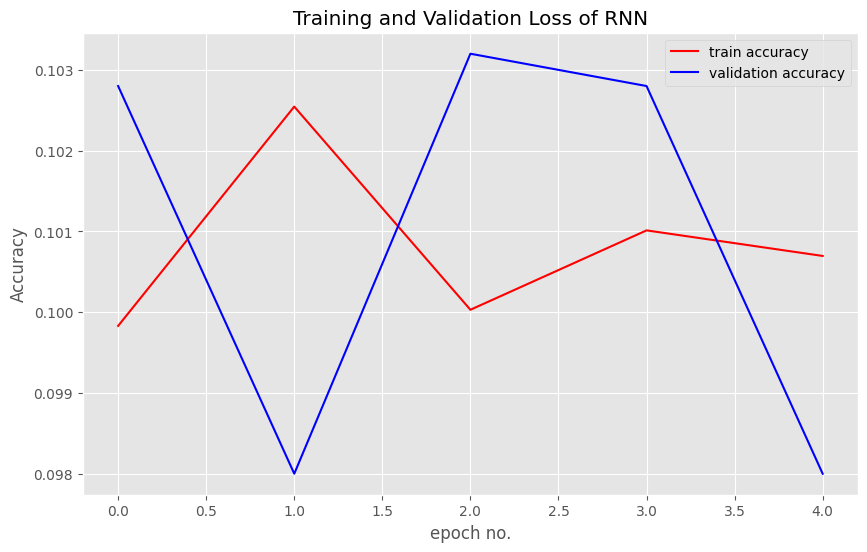

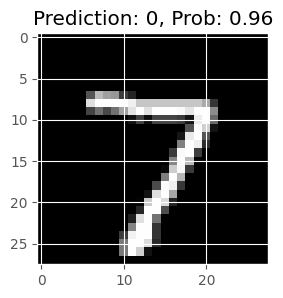

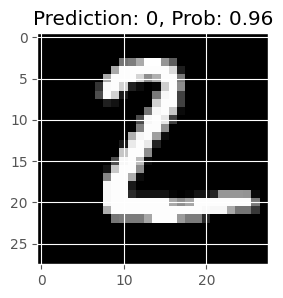

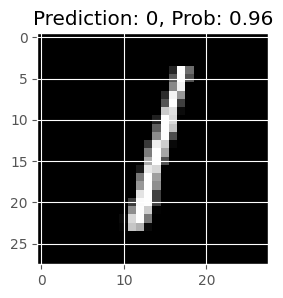

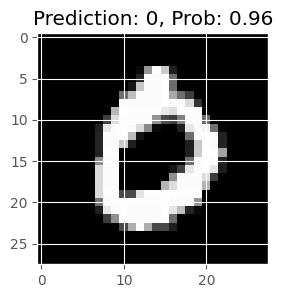

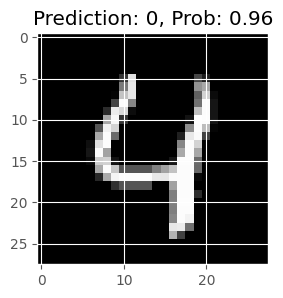

In [23]:
def main():
    # Recurrent neural network (many-to-one) 
    rnn_model, epoch_train_loss_rnn, epoch_train_acc_rnn, epoch_test_loss_rnn, epoch_test_acc_rnn = experiment(set_model=model_rnn, model_name='rnn_model', set_optimizer='Adam')
    
    plot_results(
        data=[epoch_train_loss_rnn, epoch_test_loss_rnn],
        label_names=['train loss','validation loss'],
        name_value='Loss',
        name_title='Training and Validation Loss of RNN'
    )
    plot_results(
        data=[epoch_train_acc_rnn, epoch_test_acc_rnn],
        label_names=['train accuracy','validation accuracy'],
        name_value='Accuracy',
        name_title='Training and Validation Loss of RNN'
    )

    inference_test(train_config=config_model ,model=rnn_model, batch_size_set=5)

if __name__ == "__main__":
    main()

## **<font style="color:blue">References:</font>**

- [YOUTUBE - Pytorch RNN example (Recurrent Neural Network)](https://www.youtube.com/watch?v=Gl2WXLIMvKA&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=5)
- [YOUTUBE - Pytorch Bidirectional LSTM example](https://www.youtube.com/watch?v=jGst43P-TJA&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=6)
- [GitHub - Machine-Learning-Collection](https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master)
- [YOUTUBE - PyTorch RNN Tutorial - Name Classification Using A Recurrent Neural Net](https://www.youtube.com/watch?v=WEV61GmmPrk)
- [YOUTUBE - PyTorch Tutorial - RNN & LSTM & GRU - Recurrent Neural Nets](https://www.youtube.com/watch?v=0_PgWWmauHk)
- [GitHub - pytorch-examples](https://github.com/patrickloeber/pytorch-examples/tree/master)